In [281]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import quad
from scipy.optimize import minimize_scalar 
import matplotlib.pyplot as plt

### Monte carlo

In [ ]:
def monte_carlo_estimate(probe, t):
    p = sum((1 for x in probe if x >= t))/len(probe)
    return p

### Simulation gain 
to check 

for known distribution 


In [ ]:
def simulation_gain_known(g: callable, W: callable, G: float, pdf_STD: callable, pdf_IS: callable, left_lim_STD, right_lim_STD, left_lim_IS, right_lim_IS) -> (float, float):
    '''Here G must be numer (exact evaluation from known distributions)'''
    # calculating expected values
    e_g2_STD, err_1 = quad(lambda x: g(x)**2 * pdf_STD(x), left_lim_STD, right_lim_STD)
    e_g2_IS, err_2 = quad(lambda x: g(x)*2 * W(x)**2 * pdf_IS(x), left_lim_IS, right_lim_IS)
    # calculating return values
    rtn_val = (e_g2_STD - G**2) / (e_g2_IS - G**2)
    rtn_err = max(err_1, err_2)
    return rtn_val, rtn_err
    
def simulation_gain_tail_kd(p_t: float, t: float, W: callable, pdf_IS, left_lim, right_lim) -> float:
    left_lim = max(t, left_lim)
    # TODO problem with integrating 
    mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
    rtn_val = (p_t * (1 - p_t)) / (mean - p_t**2)
    return abs(rtn_val), rtn_err
    # tutaj jest błąd to p_t też trzeba liczyć tylko wydaje mi się to całkami było by najlepiej zrobić (to jest wartośc oczekiwana że X osiągnie tę wartośc czyli po prostu całka na po gęstości)
    # to wszystko trzeba w całkach zrobić (do góry też, i błąd z tych całek ściągnąć i zrobi√ widełki z dokładnością)


### Functions for module 

derivation:

$$\hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*$$

In [ ]:
def p_estim(t: float, sample: tuple, W: callable) -> float:
    '''
    We need provide sample from $f_*$ or rearange function W which is given

    We estimate parameter $p$:
    .. math::
        \hat{p}_t = \frac{1}{K}\sum_{i=1}^K \chi_{X_i \geq t}W(X_i), X_i \sim f_*

    '''
    return sum((((x >= t and 1) or 0) * W(x) for x in sample))/len(sample)

def var_estim(t: float, sample: tuple, W: callable) -> float:
    return sum((((x >= t and 1) or 0) * W(x)**2 for x in sample))/len(sample)

def opt_density(p_t, t, pdf):
    return lambda x: ((x >= t and 1) or 1) * pdf(x) / p_t

### IS methods

#### scaling

estimating probability 

In [343]:
def fact_W_scaling(a: float, f: callable):
    '''creating W functions for IS scaling method'''
    return lambda x ,a=a: a * f(x) / f(x/a)


example from book to for checking functions (we can add this to test)

In [ ]:
# getting values for p
def p_true_gen(b, mu):
    return lambda t: np.exp(-(t/mu)**b)# weibull with var_names from book

# function for getting p_t
def p_true_gen(b, mu):
    return lambda t: np.exp(-(t/mu)**b)

def t_from_p(p, b, mu):
    return (- np.log(p))**(1/b) * mu

def w_gen(a, b, mu):
    return lambda x: a**b * np.exp(-(1-a**-b)*(x/mu)**b)

# problem is to estimate parameter a ~ scaling factor 

def opt_a(t, mu, b):
    a_e = 1/2 * (1 + (t/mu)**b + np.sqrt(1 + (t/mu)**(2*b)))
    return a_e**(1/b)
# tested 


here is good example because we p_t via IS

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\G'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:24: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_15766/3860333271.py:23: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_15766/3860333271.py:24: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('wzrost efektywności $\Gamma$')


1.4665669327511136e-08


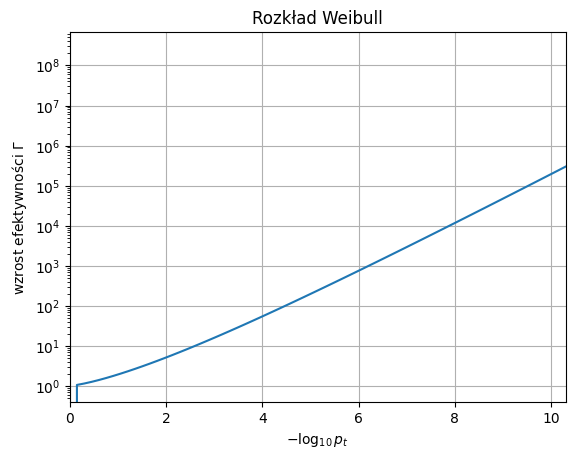

In [ ]:
# starting parameters
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)


# by vectors
density = 100
x = np.linspace(0, 10, density)
p_t_list = np.array([10**(-i/(density/10)) for i in range(density)])
t_list = [t_from_p(p_t, b, mu) for p_t in p_t_list]
a_list = [opt_a(t, mu, b) for t in t_list]
W_list = [w_gen(a, b, mu) for a in a_list]
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, 0, np.inf) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y = [val for val, err in val_err]
error = max((err for val, err in val_err))
print(error)
plt.plot(x, y)
plt.yscale('log')
plt.xlim(0, 10.3)
plt.title('Rozkład Weibull')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('wzrost efektywności $\Gamma$')
plt.grid()
plt.show()
# sprawdzone (znak ujemny wychodzi bo różnica powinna być w module)

# robimy tak: zgarniamy różne wartości p_t i na te wartości wrzucamy jak się zmienia sumulation gain to nam mówi ile więcej próbek trzeba by dac w mc by osiągnac takzą samą precyzje jak IS 

# robimy coś takiego: wybieramy coraz mniej prawdopodobne zdarzenia i spradzamy jak dla optymalnego a zwiększa się ilość próbek które potrzebujemy dobrać w metodzie monte carlo aby otrzymać podobne wyniki

rozkład normalny 

In [423]:
dist = stats.norm(loc=0, scale=1)


# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)])
W_list_a = [lambda a, x=x: a * dist.pdf(x)**2 / dist.pdf(x/a) for x in t_list]
# finding optimal values for a IMPO
a_list = [minimize_scalar(w, bounds=[max(t, 0), 10**5]).x for t, w in zip(t_list, W_list_a)]
# finding functions W
W_list = [fact_W_scaling(a, lambda x: dist.pdf(x)) for a in a_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, a=a: dist.pdf(x/a) / a for a in a_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t+30) for p_t, t, W, pdf_IS in zip(p_t_list, t_list, W_list, pdf_IS_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)



/tmp/ipykernel_15766/190451690.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return lambda x ,a=a: a * f(x) / f(x/a)
/tmp/ipykernel_15766/1927987655.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
/tmp/ipykernel_15766/1927987655.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
/tmp/ipykernel_15766/1927987655.py:13: RuntimeWarning: overflow encountered in scalar power
  mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)


1.328265402247495e-08


<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_15766/1885056848.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_15766/1885056848.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


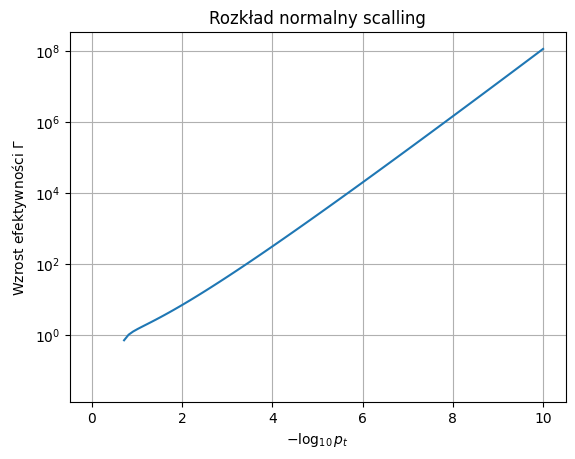

In [424]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład normalny scalling')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

#### translation

basic functions to IS

In [349]:
# density function 
def fact_W_translation(c: float, f: callable) -> callable:
    '''Return W function of translation method of importance sampling'''
    return lambda x, c=c: f(x)/f(x-c)


In [448]:
dist = stats.norm(loc=0, scale=1)


# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)])
W_list_c = [lambda c, x=x: dist.pdf(x)**2/dist.pdf(x - c) for x in t_list]
# finding optimal values for a IMPO
c_list = [minimize_scalar(w, bounds=[0, max(t*4, 0.5)]).x for t, w in zip(t_list, W_list_c)]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, c + 30) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)



1.3103259350828498e-08


In [449]:
print(list(zip(t_list, c_list)))

[(np.float64(-1.9997658101835842), np.float64(4.469534883430863e-06)), (np.float64(-0.7541616862020523), np.float64(4.469534883430863e-06)), (np.float64(-0.28980950362884617), np.float64(4.469534883430863e-06)), (np.float64(0.03331234536290301), np.float64(0.03331234664138901)), (np.float64(0.29027938245396884), np.float64(0.2902794797423591)), (np.float64(0.5077566256064416), np.float64(0.5077572142741376)), (np.float64(0.6985803420847285), np.float64(0.6985815739122718)), (np.float64(0.8700072572465791), np.float64(0.8700075380159137)), (np.float64(1.0265780448575978), np.float64(1.0265790866020121)), (np.float64(1.171341198906297), np.float64(1.1713404793683861)), (np.float64(1.3064524319414745), np.float64(1.3064524292430755)), (np.float64(1.4334981928007275), np.float64(1.4334981830292801)), (np.float64(1.553683551874124), np.float64(1.5536835247023433)), (np.float64(1.667947760363534), np.float64(1.667947698207708)), (np.float64(1.777038689256036), np.float64(1.7770385667144961))

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_15766/3163167687.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_15766/3163167687.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


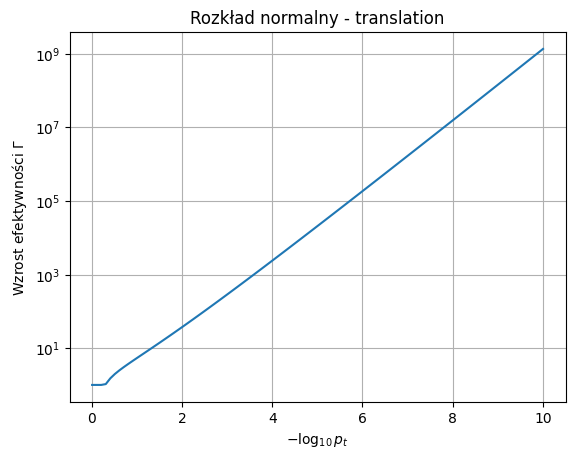

In [446]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład normalny - translation')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

Rozkład Weibull

In [464]:
b = 2
mu = 1
dist = stats.weibull_min(c=b, scale=mu)


# by vectors
density = 100
# creating args
x = list(np.linspace(0.01, 10, density))
# probabilities to check 
p_t_list = [10**(-i) for i in x]
# finding t(quantile of 1-p_t value in normal distribution) values (to minimize a value)
t_list = [dist.ppf(1-p_t) for p_t in p_t_list]
# creating W values which depends only on a (derivation I(a) = E_*[(X >= t) * W**2(X)])
W_list_c = [lambda c, x=x: dist.pdf(x)**2/dist.pdf(x - c) for x in t_list]
# finding optimal values for a IMPO
c_list = [minimize_scalar(w, bounds=[0, max(t*4, 0.5)]).x for t, w in zip(t_list, W_list_c)]
# finding functions W
W_list = [fact_W_translation(c, lambda x: dist.pdf(x)) for c in c_list]
# finding densities of IS f_*(x) = 1/a f(x/a)
pdf_IS_list = [lambda x, c=c: dist.pdf(x - c) for c in c_list]
# finding \Gamma function values 
val_err = [simulation_gain_tail_kd(p_t, t, W, pdf_IS, -np.inf, t + 0.5) for p_t, t, W, pdf_IS, c in zip(p_t_list, t_list, W_list, pdf_IS_list, c_list)]
y = [val for val, err in val_err]

error = max((err for val, err in val_err))
print(error)


/tmp/ipykernel_15766/281166547.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  W_list_c = [lambda c, x=x: dist.pdf(x)**2/dist.pdf(x - c) for x in t_list]
/home/max/.pyenv/versions/3.12.7/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2288: RuntimeWarning: invalid value encountered in scalar subtract
  r = (xf - nfc) * (fx - ffulc)
/home/max/.pyenv/versions/3.12.7/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2289: RuntimeWarning: invalid value encountered in scalar subtract
  q = (xf - fulc) * (fx - fnfc)
/tmp/ipykernel_15766/1787585910.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return lambda x, c=c: f(x)/f(x-c)
/tmp/ipykernel_15766/1927987655.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  mean, rtn_err = quad(lambda x: W(x)**2 * pdf_IS(x), left_lim, right_lim)
/tmp/ipykernel_15766/1927987655.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested t

nan


In [467]:
t_list

[np.float64(0.15174271293851468),
 np.float64(0.5053490075233097),
 np.float64(0.6983762509418886),
 np.float64(0.8485759579168513),
 np.float64(0.9759267005412626),
 np.float64(1.0884781547207132),
 np.float64(1.1904354084867699),
 np.float64(1.2843240363140123),
 np.float64(1.371801734482345),
 np.float64(1.4540260545133377),
 np.float64(1.5318431824695626),
 np.float64(1.6058939268062913),
 np.float64(1.6766773907428298),
 np.float64(1.7445913106235045),
 np.float64(1.8099587314571268),
 np.float64(1.873046282944644),
 np.float64(1.934077078745208),
 np.float64(1.9932400545349411),
 np.float64(2.050696877521713),
 np.float64(2.1065871574544834),
 np.float64(2.1610324431685446),
 np.float64(2.214139333669375),
 np.float64(2.26600193234179),
 np.float64(2.316703806241006),
 np.float64(2.3663195672449744),
 np.float64(2.414916160615372),
 np.float64(2.4625539245417825),
 np.float64(2.509287468535839),
 np.float64(2.5551664071496085),
 np.float64(2.6002359771183667),
 np.float64(2.64453

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_15766/1862676929.py:6: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$-\log_{10}p_t$')
/tmp/ipykernel_15766/1862676929.py:7: SyntaxWarning: invalid escape sequence '\G'
  plt.ylabel('Wzrost efektywności $\Gamma$')


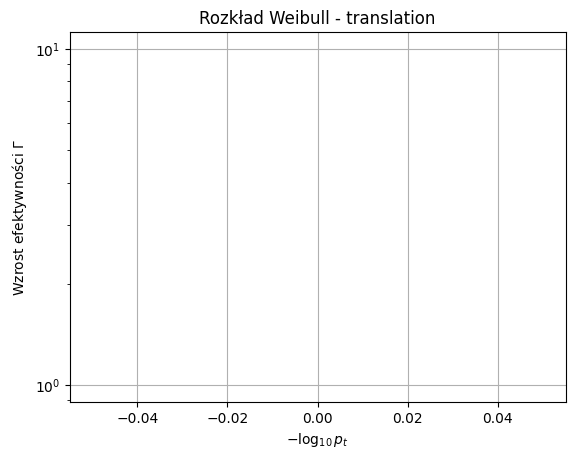

In [454]:
plt.plot(x, y)
plt.yscale('log')
# plt.ylim([0, 10**11])
# plt.xlim(0, 10.3)
plt.title('Rozkład Weibull - translation')
plt.xlabel('$-\log_{10}p_t$')
plt.ylabel('Wzrost efektywności $\Gamma$')
plt.grid()
plt.show()

example of calculating, they show it for normal distribution, (for every distribution we obtain something different how to generlize that problem)

combine scaling and translation 